In [73]:
import hydra
import torch
from lib.utils.config import load_config
from lib.optimizer.framework import NeuralOptimizer
from lib.data.loader import load_intrinsics
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera
from lib.utils.visualize import visualize_point2plane_error
import matplotlib.pyplot as plt


def path_to_abblation(path):
    return "_".join(path.split("/")[-3].split("_")[1:])


def eval_iterations(optimizer, datamodule, idx: int):
    optimizer.max_iters = 5
    optimizer.max_optims = 1
    out = None
    batch = None
    for i, b in enumerate(datamodule.val_dataloader()):
        if i == idx:
            with torch.no_grad():
                batch = optimizer.transfer_batch_to_device(b, "cuda", 0)
                out = optimizer(batch)
    return out, batch

def draw_and_save(img, path):
    # Display and save the error image
    plt.figure(figsize=(19.2, 10.8), dpi=100)  # Full HD size
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.savefig(path, bbox_inches='tight', pad_inches=0)  # Save without padding
    plt.show()

def load_flame_renderer():
    # instanciate similar to training
    cfg = load_config("train", ["data=kinect"])
    K = load_intrinsics(data_dir=cfg.data.intrinsics_dir, return_tensor="pt")
    camera = Camera(
        K=K,
        width=cfg.data.width,
        height=cfg.data.height,
        near=cfg.data.near,
        far=cfg.data.far,
        scale=cfg.data.scale,
    )
    rasterizer = Rasterizer(width=camera.width, height=camera.height)
    renderer = Renderer(rasterizer=rasterizer, camera=camera)
    flame = hydra.utils.instantiate(cfg.model)
    return flame, renderer

def render_output(renderer, optimizer, out, batch):
    renderer.update(scale=1)
    pred_out = optimizer.flame.render(renderer, out["params"])
    gt_out = optimizer.flame.render(renderer, batch["params"])
    error_map = visualize_point2plane_error(
        s_point=gt_out["point"][0],
        t_normal=pred_out["normal"][0],
        t_point=pred_out["point"][0],
        t_mask=pred_out["mask"][0],
        max_error=2e-03,  # 2mm
    )
    renderer.update(scale=8)
    color = pred_out["color"][0].detach().cpu()
    return color, error_map


def load_neural_optimizer(flame, renderer, path, override=[]):
    cfg = load_config("train", ["data=kinect"] + override)
    correspondence = hydra.utils.instantiate(cfg.correspondence)
    weighting = hydra.utils.instantiate(cfg.weighting)
    residuals = hydra.utils.instantiate(cfg.residuals)
    regularize = hydra.utils.instantiate(cfg.regularize)
    neural_optimizer = NeuralOptimizer.load_from_checkpoint(
        path,
        renderer=renderer,
        flame=flame,
        correspondence=correspondence,
        regularize=regularize,
        residuals=residuals,
        weighting=weighting,
    )
    return neural_optimizer


# setup the datamodule
def load_datamodule(renderer, start_frame, end_frame, jump_size=1):
    cfg = load_config("train", ["data=kinect"])
    datamodule = hydra.utils.instantiate(
        cfg.data,
        renderer=renderer,
        val_dataset=dict(
            start_frame=start_frame,
            end_frame=end_frame,
            jump_size=jump_size
        ),
    )
    datamodule.setup("fit")
    return datamodule

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


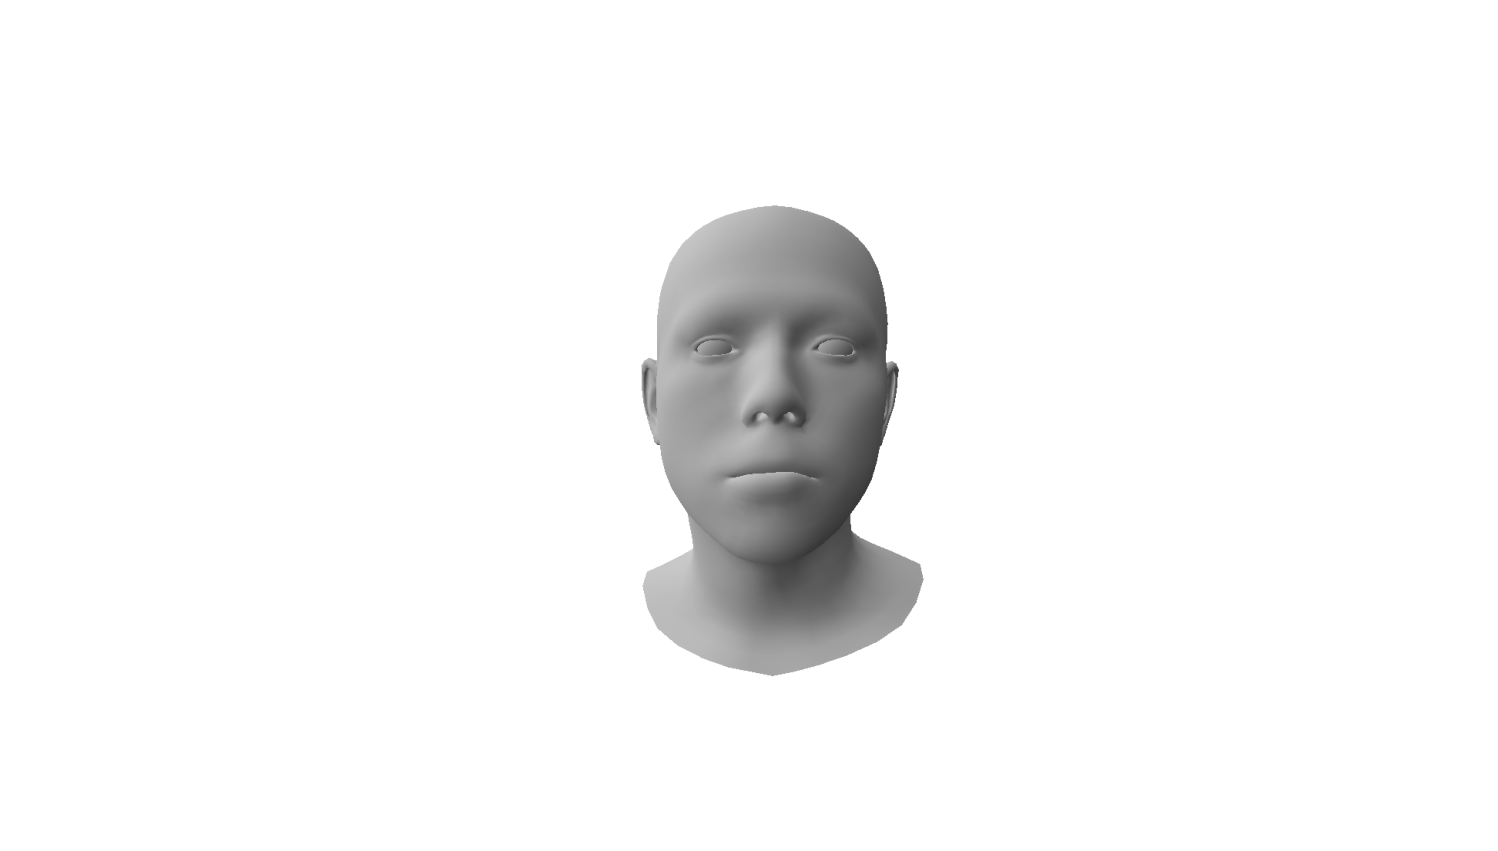

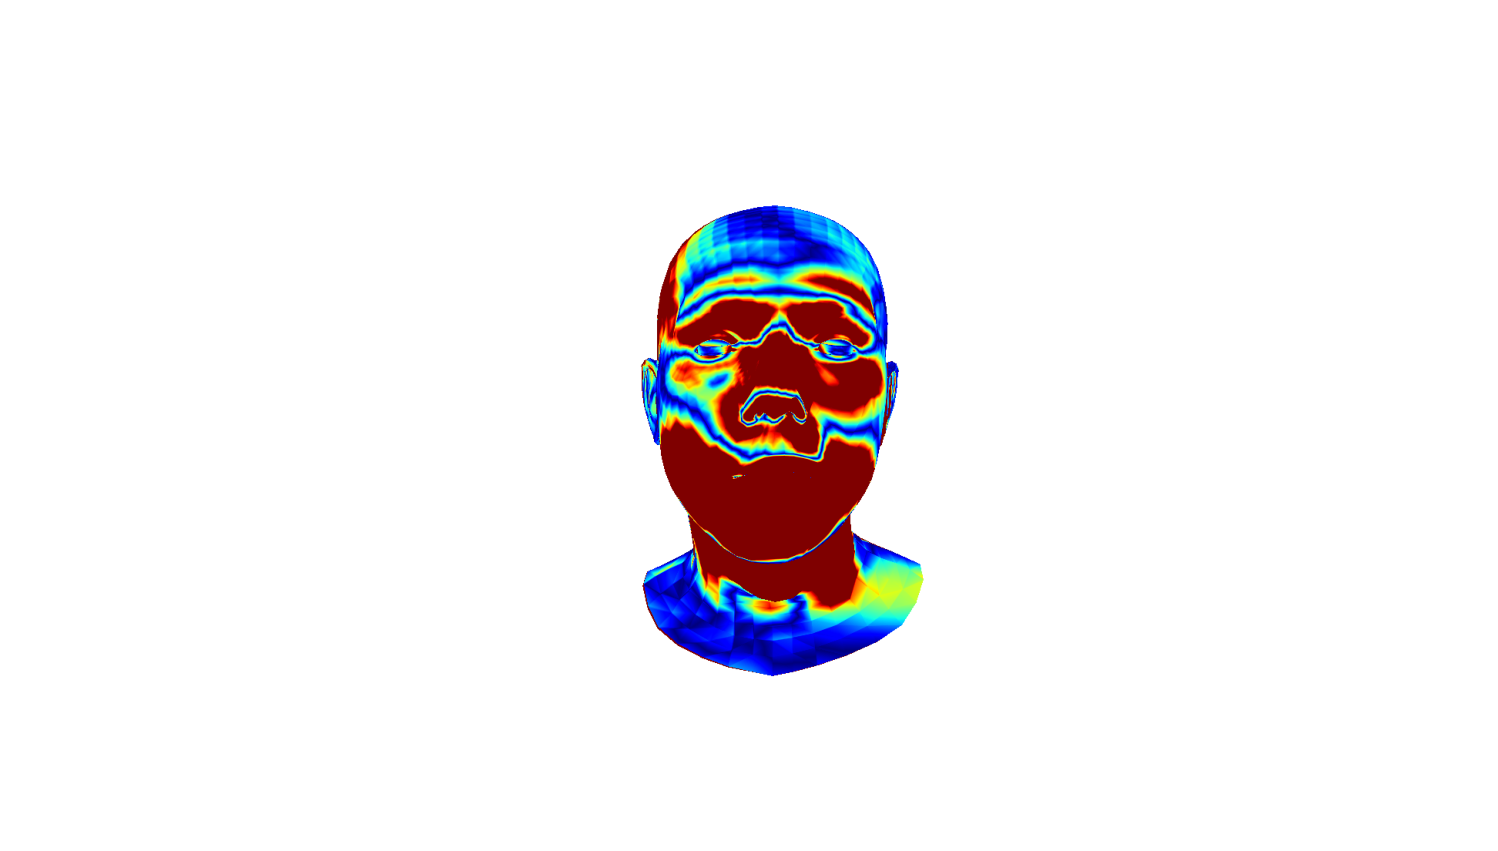

In [74]:
# settings
step_size = 0.7
idx = 3
start_frame = 52
end_frame = 53

# checkpoints
wo_neural_weights = "/home/borth/GuidedResearch/checkpoints/synthetic_lr/wo_neural_weights.ckpt"
ours = "/home/borth/GuidedResearch/checkpoints/synthetic_lr/ours2.ckpt"

# loadings
flame, renderer = load_flame_renderer()
datamodule = load_datamodule(renderer, start_frame, end_frame, 4)

# optim
path = ours
optimizer = load_neural_optimizer(flame, renderer, path)
optimizer.optimizer.step_size = step_size
out, batch = eval_iterations(optimizer, datamodule, idx)
tmp_out = optimizer.flame.render(renderer, batch["init_params"]) 
batch["mask"] = tmp_out["mask"]
batch["color"] = tmp_out["color"]
batch["normal"] = tmp_out["normal"]
batch["point"] = tmp_out["point"]
out = optimizer(batch)
color, error = render_output(renderer, optimizer, out, batch)
draw_and_save(color, f"results/method/ours_color_{idx}.png")
draw_and_save(error, f"results/method/ours_error_{idx}.png")

# base
# out["params"] = batch["init_params"]
# color, error = render_output(renderer, optimizer, out, batch)
# draw_and_save(color, f"results/method/init_color_{idx}.png")
# out["params"] = batch["params"]
# color, error = render_output(renderer, optimizer, out, batch)
# draw_and_save(color, f"results/method/gt_color_{idx}.png")

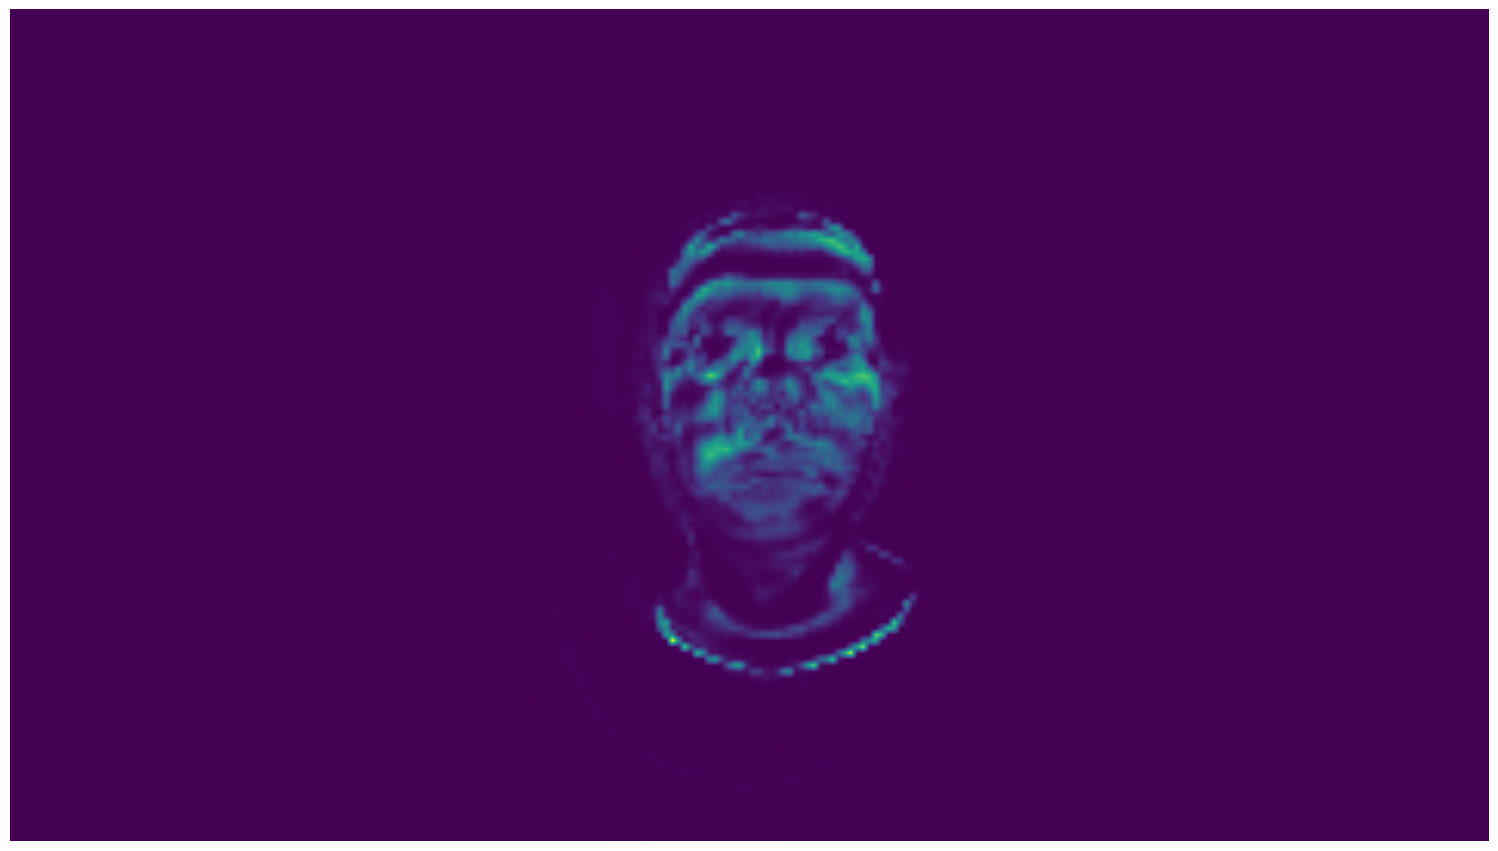

In [93]:
import torch
import torch.nn.functional as F

weights = out["optim_weights"][4]
# Rescale weights by a factor of 8
scale_factor = 8
rescaled_weights = F.interpolate(weights.unsqueeze(0), scale_factor=scale_factor, mode='bilinear', align_corners=False)
plt.figure(figsize=(19.2, 10.8), dpi=100)  # Full HD size
plt.imshow(rescaled_weights.detach()[0][0].cpu().numpy())
plt.axis('off')  # Hide axes
plt.show()

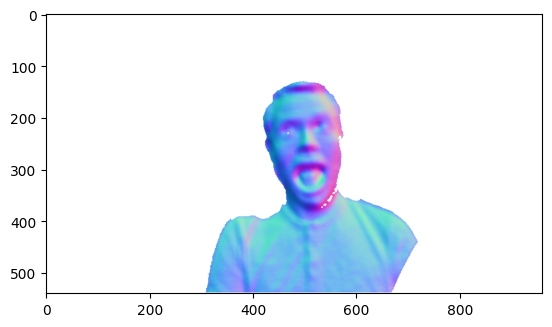

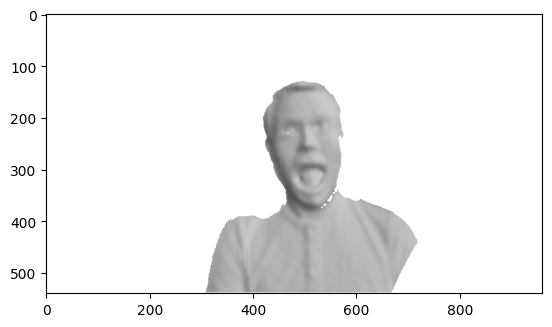

In [57]:
idx = 52
mask = torch.load(f"/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove/cache/2_mask/{idx:05}.pt")
normal = torch.load(f"/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove/cache/2_normal/{idx:05}.pt")

normal_image = renderer.normal_to_normal_image(normal.unsqueeze(0), mask.unsqueeze(0))
plt.imshow(normal_image[0].detach().cpu().numpy())
plt.show()

gray_image = normal_image.to(torch.float32).mean(dim=-1, keepdim=True).to(torch.uint8)
gray_image = torch.cat([gray_image, gray_image, gray_image], dim=-1)
plt.imshow(gray_image[0].detach().cpu().numpy())
plt.show()

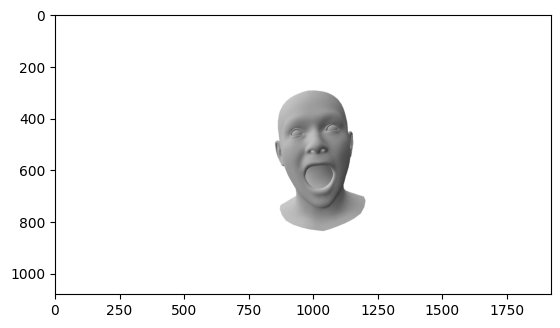

In [64]:
path ="/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove/params/00052.pt"
params = torch.load(path)
params = optimizer.transfer_batch_to_device(params, "cuda", 0)
renderer.update(1)
out = optimizer.flame.render(renderer, params)
plt.imshow(out["color"][0].detach().cpu().numpy())
renderer.update(8)